In [1]:
# --------------------------------------------
# Phishing URL Detection with Machine Learning
# --------------------------------------------
# scikit-learn
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import re
from urllib.parse import urlparse

# For handling imbalance
from imblearn.over_sampling import SMOTE

In [2]:
# Step 2: Load Dataset
data = pd.read_csv("phishing_site_urls.csv")

print("👩‍💻 Loading dataset...")
print("📊 Dataset Shape:", data.shape)
print("📝 Available columns:", data.columns.tolist())

# Step 2a: Ensure correct column names
possible_url_cols = ['url', 'URL', 'Url', 'Domain', 'Link']
possible_label_cols = ['label', 'Label', 'target', 'Target', 'class']

url_col = next((col for col in data.columns if col in possible_url_cols), None)
label_col = next((col for col in data.columns if col in possible_label_cols), None)

if url_col is None:
    raise ValueError("⚠️ No URL column found! Please check your dataset.")
if label_col is None:
    raise ValueError("⚠️ No label column found! Please check your dataset.")

# Rename for consistency
data.rename(columns={url_col: 'url', label_col: 'label'}, inplace=True)

# Step 2b: Clean missing values
print("\n🧹 Cleaning dataset...")
data.dropna(subset=['url', 'label'], inplace=True)

# Step 2c: Convert labels to numeric if needed
if data['label'].dtype == 'object':
    data['label'] = data['label'].map({
        'phishing': 1, 'Phishing': 1, 'bad': 1, 'malicious': 1,
        'legitimate': 0, 'Legitimate': 0, 'good': 0, 'safe': 0
    }).fillna(data['label'])

data['label'] = pd.to_numeric(data['label'], errors='coerce')
data.dropna(subset=['label'], inplace=True)
data['label'] = data['label'].astype(int)

print("✅ Data cleaned! Remaining rows:", data.shape[0])

👩‍💻 Loading dataset...
📊 Dataset Shape: (549346, 2)
📝 Available columns: ['URL', 'Label']

🧹 Cleaning dataset...
✅ Data cleaned! Remaining rows: 549346


In [3]:
# Step 3: Feature Extraction
print("\n🔎 Extracting features...")
# Most popular words in phishing URLs
def extract_features(url):
    features = {}
    
    try:
        parsed = urlparse(url)
    except:
        # If URL parsing fails, use original url
        parsed = None
    
    # Basic counts
    features['url_length'] = len(url)
    features['num_dots'] = url.count('.')
    features['num_hyphens'] = url.count('-')
    features['num_at'] = url.count('@')
    features['num_equal'] = url.count('=')
    features['num_slash'] = url.count('/')
    features['num_question'] = url.count('?')
    features['num_ampersand'] = url.count('&')
    features['num_percent'] = url.count('%')
    features['num_underscore'] = url.count('_')
    features['num_tilde'] = url.count('~')
    features['num_semicolon'] = url.count(';')
    
    # Check for www (case-insensitive, whole word)
    features['has_www'] = 1 if re.search(r'\bwww\b', url.lower()) else 0
    
    # Special characters count (excluding protocol and www prefix)
    url_without_protocol = re.sub(r'^https?://(www\.)?', '', url, flags=re.IGNORECASE)
    features['num_special_chars'] = len(re.findall(r'[^a-zA-Z0-9]', url_without_protocol))
    
    # TLD detection (more accurate pattern)
    # Matches .com, .co.uk, .org, etc.
    tld_matches = re.findall(r'\.[a-z]{2,}(?:\.[a-z]{2,})?(?=[/?#]|$)', url.lower())
    features['num_tld'] = len(tld_matches)
    
    # Extract actual TLD (rightmost domain component)
    if parsed and parsed.netloc:
        domain_parts = parsed.netloc.lower().split('.')
        if len(domain_parts) >= 2:
            # Get TLD length (e.g., 'com' = 3, 'co.uk' = 5)
            features['tld_length'] = len(domain_parts[-1])
            # Check for suspicious/uncommon TLDs
            suspicious_tlds = ['.xyz', '.top', '.tk', '.ml', '.ga', '.cf', '.gq', '.pw', '.cc']
            features['has_suspicious_tld'] = 1 if any(tld in url.lower() for tld in suspicious_tlds) else 0
        else:
            features['tld_length'] = 0
            features['has_suspicious_tld'] = 0
    else:
        features['tld_length'] = 0
        features['has_suspicious_tld'] = 0
    
    # Subdomain counting (more accurate)
    if parsed and parsed.netloc:
        domain_parts = parsed.netloc.split('.')
        # Remove www from count if present
        if domain_parts and domain_parts[0].lower() == 'www':
            domain_parts = domain_parts[1:]
        # Subdomains = total parts - 2 (domain + tld) or - 3 for compound TLDs like .co.uk
        # Simplified: count dots in netloc minus 1 (for main domain.tld)
        features['num_subdomains'] = max(0, parsed.netloc.count('.') - 1)
    else:
        # Fallback to original logic
        features['num_subdomains'] = max(0, url.count('.') - 1)
    
    # ========== NEW: Main Domain Structure Analysis ==========
    if parsed and parsed.netloc:
        netloc = parsed.netloc.lower()
        # Remove port if present
        netloc_no_port = netloc.split(':')[0]
        domain_parts = netloc_no_port.split('.')
        
        # Extract main domain (second-level domain)
        if len(domain_parts) >= 2:
            # Skip www if present
            if domain_parts[0] == 'www':
                main_domain = domain_parts[1] if len(domain_parts) > 2 else domain_parts[0]
            else:
                main_domain = domain_parts[-2]  # e.g., 'google' from 'www.google.com'
            
            # Main domain features
            features['domain_length'] = len(main_domain)
            features['domain_has_digits'] = 1 if any(c.isdigit() for c in main_domain) else 0
            features['domain_digit_count'] = sum(c.isdigit() for c in main_domain)
            features['domain_has_hyphen'] = 1 if '-' in main_domain else 0
            features['domain_hyphen_count'] = main_domain.count('-')
            
            # Domain entropy (randomness measure)
            def calculate_entropy(text):
                from collections import Counter
                import math
                if not text:
                    return 0
                counts = Counter(text)
                length = len(text)
                entropy = -sum((count/length) * math.log2(count/length) for count in counts.values())
                return entropy
            
            features['domain_entropy'] = calculate_entropy(main_domain)
            
            # Vowel/consonant ratio in domain (random domains often have unusual ratios)
            vowels = 'aeiou'
            vowel_count = sum(1 for c in main_domain if c in vowels)
            consonant_count = sum(1 for c in main_domain if c.isalpha() and c not in vowels)
            total_letters = vowel_count + consonant_count
            features['domain_vowel_ratio'] = vowel_count / total_letters if total_letters > 0 else 0
            
            # Check for repeated characters (e.g., 'gooogle', 'payppal')
            max_consecutive = max((len(list(group)) for char, group in __import__('itertools').groupby(main_domain)), default=0)
            features['domain_max_consecutive_chars'] = max_consecutive
            
            # Check if domain name mimics popular brands (typosquatting detection)
            popular_brands = ['google', 'facebook', 'paypal', 'amazon', 'microsoft', 'apple', 
                            'netflix', 'instagram', 'twitter', 'linkedin', 'ebay', 'yahoo']
            # Calculate minimum edit distance to popular brands
            def levenshtein_distance(s1, s2):
                if len(s1) < len(s2):
                    return levenshtein_distance(s2, s1)
                if len(s2) == 0:
                    return len(s1)
                previous_row = range(len(s2) + 1)
                for i, c1 in enumerate(s1):
                    current_row = [i + 1]
                    for j, c2 in enumerate(s2):
                        insertions = previous_row[j + 1] + 1
                        deletions = current_row[j] + 1
                        substitutions = previous_row[j] + (c1 != c2)
                        current_row.append(min(insertions, deletions, substitutions))
                    previous_row = current_row
                return previous_row[-1]
            
            min_brand_distance = min((levenshtein_distance(main_domain, brand) for brand in popular_brands), default=10)
            features['min_brand_edit_distance'] = min_brand_distance
            features['is_brand_typosquat'] = 1 if 0 < min_brand_distance <= 2 else 0
            
        else:
            features['domain_length'] = 0
            features['domain_has_digits'] = 0
            features['domain_digit_count'] = 0
            features['domain_has_hyphen'] = 0
            features['domain_hyphen_count'] = 0
            features['domain_entropy'] = 0
            features['domain_vowel_ratio'] = 0
            features['domain_max_consecutive_chars'] = 0
            features['min_brand_edit_distance'] = 10
            features['is_brand_typosquat'] = 0
    else:
        features['domain_length'] = 0
        features['domain_has_digits'] = 0
        features['domain_digit_count'] = 0
        features['domain_has_hyphen'] = 0
        features['domain_hyphen_count'] = 0
        features['domain_entropy'] = 0
        features['domain_vowel_ratio'] = 0
        features['domain_max_consecutive_chars'] = 0
        features['min_brand_edit_distance'] = 10
        features['is_brand_typosquat'] = 0
    
    # ========== END NEW FEATURES ==========
    
    # Character type counts
    features['num_numeric'] = len(re.findall(r'\d', url))
    features['num_letters'] = len(re.findall(r'[a-zA-Z]', url))
    features['num_uppercase'] = len(re.findall(r'[A-Z]', url))
    features['num_lowercase'] = len(re.findall(r'[a-z]', url))
    
    # Ratios (avoid division by zero)
    url_len = features['url_length'] if features['url_length'] > 0 else 1
    features['digit_to_length_ratio'] = features['num_numeric'] / url_len
    features['letters_to_length_ratio'] = features['num_letters'] / url_len
    features['special_to_length_ratio'] = features['num_special_chars'] / url_len
    features['hyphens_to_length_ratio'] = features['num_hyphens'] / url_len
    features['dots_to_length_ratio'] = features['num_dots'] / url_len
    
    # Path and query length
    if parsed:
        features['path_length'] = len(parsed.path) if parsed.path else 0
        features['query_length'] = len(parsed.query) if parsed.query else 0
        features['hostname_length'] = len(parsed.netloc) if parsed.netloc else 0
        
        # NEW: Path depth (number of directories)
        features['path_depth'] = len([p for p in parsed.path.split('/') if p]) if parsed.path else 0
        
        # NEW: Number of parameters in query string
        features['num_query_params'] = len(parsed.query.split('&')) if parsed.query else 0
        
        # NEW: Fragment presence
        features['has_fragment'] = 1 if parsed.fragment else 0
        
        # NEW: Port presence and suspicious ports
        if parsed.port:
            features['has_custom_port'] = 1
            # Common suspicious ports for phishing
            features['has_suspicious_port'] = 1 if parsed.port in [8080, 8888, 3000, 4443, 5000] else 0
        else:
            features['has_custom_port'] = 0
            features['has_suspicious_port'] = 0
    else:
        features['path_length'] = 0
        features['query_length'] = 0
        features['hostname_length'] = 0
        features['path_depth'] = 0
        features['num_query_params'] = 0
        features['has_fragment'] = 0
        features['has_custom_port'] = 0
        features['has_suspicious_port'] = 0
    
    # Suspicious keywords (case-insensitive search)
    suspicious_keywords = [
        'login', 'verify', 'update', 'bank', 'secure', 'account', 
        'free', 'bonus', 'click', 'offer', 'xml', 'php', 'exe', 
        'zip', 'wp', 'paypal', 'admin', 'amp', 'signin', 'password',
        'confirm', 'suspended', 'billing', 'unlock', 'validate', 'authenticate'
    ]
    url_lower = url.lower()
    features['num_suspicious_words'] = sum(1 for kw in suspicious_keywords if kw in url_lower)
    features['has_suspicious_words'] = 1 if features['num_suspicious_words'] > 0 else 0
    
    # TLD checks (case-insensitive)
    popular_tlds = ['.com', '.org', '.net', '.edu', '.gov']
    features['has_popular_tld'] = 1 if any(tld in url_lower for tld in popular_tlds) else 0
    
    # Protocol checks
    features['has_https'] = 1 if url.lower().startswith('https://') else 0
    features['has_http'] = 1 if url.lower().startswith('http://') else 0
    
    # IP address in URL (potential phishing indicator)
    features['has_ip_address'] = 1 if re.search(r'(\d{1,3}\.){3}\d{1,3}', url) else 0
    
    # Shortened URL services
    shorteners = ['bit.ly', 'tinyurl', 'goo.gl', 't.co', 'ow.ly', 'is.gd', 'buff.ly']
    features['is_shortened'] = 1 if any(short in url_lower for short in shorteners) else 0
    
    # NEW: Double slash in path (suspicious)
    features['has_double_slash'] = 1 if '//' in url.replace('://', '') else 0
    
    # NEW: Prefix/suffix separator (e.g., paypal-secure.com)
    if parsed and parsed.netloc:
        features['has_prefix_suffix'] = 1 if '-' in parsed.netloc else 0
    else:
        features['has_prefix_suffix'] = 0
    
    return features

feature_list = [extract_features(u) for u in data['url']]
features_df = pd.DataFrame(feature_list)
features_df['label'] = data['label'].values


🔎 Extracting features...


/tmp/ipykernel_80803/687955899.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_freq.values, y=word_freq.index, palette='viridis')


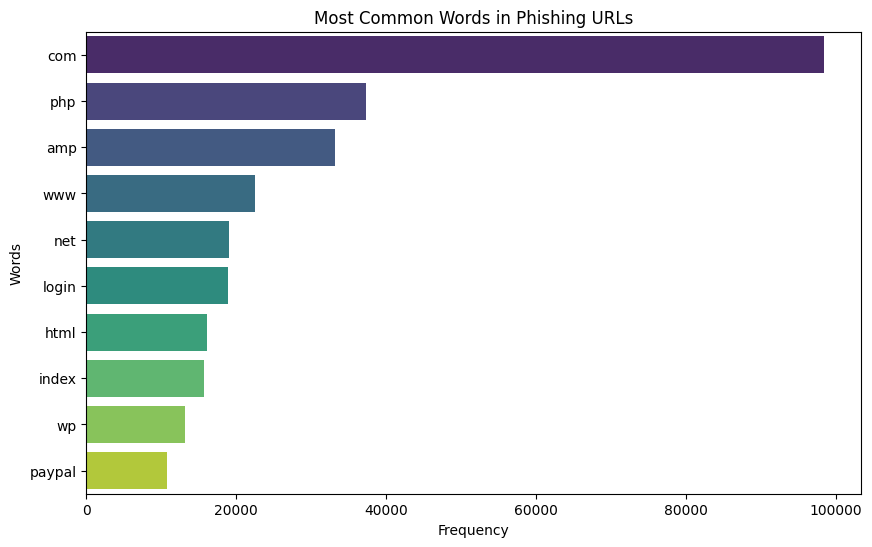

In [4]:
# Most popular words in phishing URLs
all_urls = ' '.join(data[data['label'] == 1]['url'].tolist()).lower()
word_list = re.findall(r'\b\w+\b', all_urls)
word_freq = pd.Series(word_list).value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=word_freq.values, y=word_freq.index, palette='viridis')
plt.title("Most Common Words in Phishing URLs")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

In [5]:
features_df

url_length  num_dots  num_hyphens  num_at  num_equal  num_slash  \
0              225         6            4       0          4         10   
1               81         5            2       0          2          4   
2              177         7            1       0          0         11   
3               60         6            0       0          0          2   
4              116         1            1       0          0         10   
...            ...       ...          ...     ...        ...        ...   
549341          15         3            0       0          0          1   
549342          18         1            1       0          0          1   
549343          17         1            1       0          0          1   
549344          18         1            1       0          0          1   
549345          17         1            1       0          0          0   

        num_question  num_ampersand  num_percent  num_underscore  ...  \
0                  1              3            0               4  ...   
1                  0              1            0               1  ...   
2                  0              0            0               0  ...   
3                  0              0            0               0  ...   
4                  1              0            0               0  ...   
...              ...            ...          ...             ...  ...   
549341             0              0            0               0  ...   
549342             0              0            0               0  ...   
549343             0              0            0               0  ...   
549344             0              0            0               0  ...   
549345             0              0            0               0  ...   

        num_suspicious_words  has_suspicious_words  has_popular_tld  \
0                          2                     1                1   
1                          2                     1                1   
2                          3                     1                1   
3                          0                     0                1   
4                          1                     1                1   
...                      ...                   ...              ...   
549341                     0                     0                0   
549342                     0                     0                1   
549343                     0                     0                1   
549344                     0                     0                1   
549345                     0                     0                0   

        has_https  has_http  has_ip_address  is_shortened  has_double_slash  \
0               0         0               0             0                 0   
1               0         0               0             0                 0   
2               0         0               0             0                 0   
3               0         0               0             0                 0   
4               0         0               0             0                 1   
...           ...       ...             ...           ...               ...   
549341          0         0               1             0                 0   
549342          0         0               0             0                 0   
549343          0         0               0             0                 0   
549344          0         0               0             0                 0   
549345          0         0               0             0                 0   

        has_prefix_suffix  label  
0                       0      1  
1                       0      1  
2                       0      1  
3                       0      1  
4                       0      1  
...                   ...    ...  
549341                  0      1  
549342                  0      1  
549343                  0      1  
549344                  0      1  
549345                  0      1  

[549346

<Axes: >

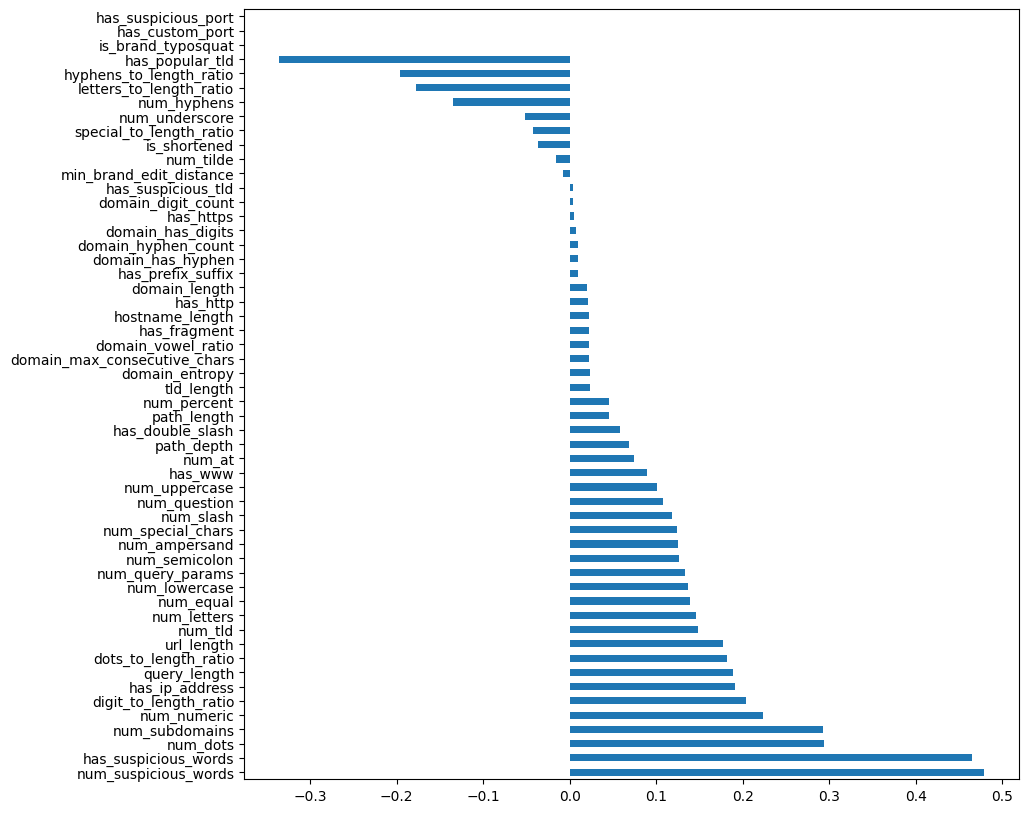

In [6]:
numeric_cols = features_df.select_dtypes(include=[np.number]).columns
correlation_values = features_df[numeric_cols].corr()['label'].drop(['label']).sort_values(ascending=False)
correlation_values.plot(kind='barh', figsize=(10, 10))

In [7]:
# Step 4: Feature Selection
# Scaling features first
# print("\n⚙️ Scaling features...")
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features_df.drop('label', axis=1))
# features_scaled_df = pd.DataFrame(features_scaled, columns=features_df.columns[:-1])

# features_scaled_df

In [8]:
# Selecting features based on correlation
# # No need to select features based on threshold since we are using all features as using all features has the best performance
# selected_features = correlation_values[abs(correlation_values) > 0.1].index.tolist()
# print("\n🔧 Selected features based on correlation threshold:", selected_features)
# print(len(selected_features), "features selected out of", len(correlation_values))

# features_scaled_df = features_scaled_df[selected_features]

In [9]:
# Step 4: Prepare Final Dataset
X = features_df.drop('label', axis=1)
y = data['label']

print("📐 Features Extracted:", X.shape[1])
print("⚖️ Labels distribution before balancing:\n", y.value_counts())

📐 Features Extracted: 54
⚖️ Labels distribution before balancing:
 label
0    392924
1    156422
Name: count, dtype: int64


In [10]:
# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 5b: Balance the training set using SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

print("⚖️ Labels distribution after balancing:\n", y_train.value_counts())


⚖️ Labels distribution after balancing:
 label
0    314339
1    314339
Name: count, dtype: int64


In [11]:
print("\n🤖 Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
rf_model.fit(X_train, y_train)
print("✅ Model training complete!")


🤖 Training Random Forest model...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min


✅ Model training complete!


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.4min finished


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.6s finished



📊 Model Evaluation
🎯 Accuracy: 92.14 %

📝 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94     78585
           1       0.85      0.88      0.86     31285

    accuracy                           0.92    109870
   macro avg       0.90      0.91      0.90    109870
weighted avg       0.92      0.92      0.92    109870



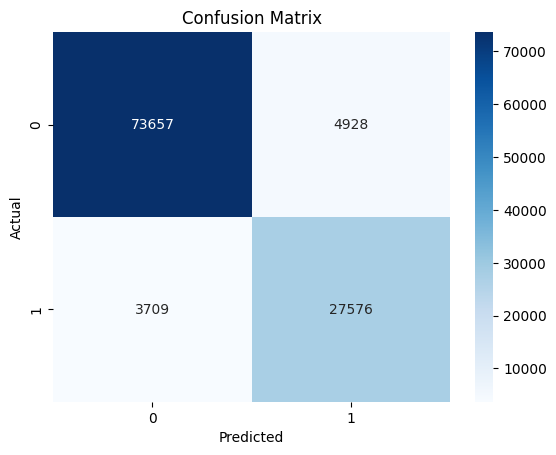

In [12]:
# Step 7: Evaluation
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\n📊 Model Evaluation")
print("🎯 Accuracy:", round(accuracy * 100, 2), "%")
print("\n📝 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [13]:
# Step 6b: Save and load the tuned Random Forest model
import joblib
model_path = 'rf_tuned_model.joblib'
joblib.dump(rf_model, model_path)
print(f"✅ Saved tuned Random Forest to {model_path}")

# Load back to verify
loaded_rf = joblib.load(model_path)
print("Loaded model type:", type(loaded_rf))

# Quick sanity check with a few test samples (if available)
try:
    sample_input = X_test.iloc[:5]
except Exception:
    sample_input = X_test[:5]

if len(sample_input) > 0:
    sample_preds = loaded_rf.predict(sample_input)
    print("Sample predictions:", sample_preds)

✅ Saved tuned Random Forest to rf_tuned_model.joblib
Loaded model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Sample predictions: [0 1 1 0 0]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [14]:
# Step 8: Chat-Style URL Checker
def check_url(url, debug=False):
    predict_features = extract_features(url)
    predict_features_df = pd.DataFrame([predict_features])
      
    # Transform with scaler (use transform, NOT fit_transform!)
    # predict_features_scaled = scaler.transform(predict_features_df)
    
    # Convert back to DataFrame with proper column names to avoid warning
    predict_features_scaled = pd.DataFrame(
        predict_features_df, 
        columns=features_df.columns[:-1]  # All columns except 'label'
    )
    
    # Make prediction with probability
    prediction = rf_model.predict(predict_features_scaled)[0]
    probabilities = rf_model.predict_proba(predict_features_scaled)[0]
    
    print("\n👤 User:", url)
    if prediction == 1:
        print(f"🤖 Bot: 🚨 Warning! This looks like a *Phishing URL*. (Confidence: {probabilities[1]*100:.1f}%)")
    else:
        print(f"🤖 Bot: ✅ Safe! This seems like a *Legitimate URL*. (Confidence: {probabilities[0]*100:.1f}%)")
    
    # Debug mode - show key features
    if debug:
        print("\n🔍 Debug Info:")
        print(f"  • URL Length: {predict_features['url_length']}")
        print(f"  • Domain: {predict_features.get('domain_length', 'N/A')} chars")
        print(f"  • Has HTTPS: {predict_features['has_https']}")
        print(f"  • Suspicious Words: {predict_features['num_suspicious_words']}")
        print(f"  • Popular TLD: {predict_features['has_popular_tld']}")
        print(f"  • Min Brand Distance: {predict_features['min_brand_edit_distance']}")
        print(f"  • Is Typosquat: {predict_features['is_brand_typosquat']}")
        print(f"  • Subdomains: {predict_features['num_subdomains']}")
        print(f"\n  Probability [Legitimate, Phishing]: {probabilities}")

# Example chat tests
check_url("openai.com/verify", debug=True)
check_url("http://secure-login-bank.com/verify", debug=True)


👤 User: openai.com/verify
🤖 Bot: ✅ Safe! This seems like a *Legitimate URL*. (Confidence: 51.0%)

🔍 Debug Info:
  • URL Length: 17
  • Domain: 0 chars
  • Has HTTPS: 0
  • Suspicious Words: 1
  • Popular TLD: 1
  • Min Brand Distance: 10
  • Is Typosquat: 0
  • Subdomains: 0

  Probability [Legitimate, Phishing]: [0.51026536 0.48973464]

👤 User: http://secure-login-bank.com/verify
🤖 Bot: 🚨 Warning! This looks like a *Phishing URL*. (Confidence: 63.2%)

🔍 Debug Info:
  • URL Length: 35
  • Domain: 17 chars
  • Has HTTPS: 0
  • Suspicious Words: 4
  • Popular TLD: 1
  • Min Brand Distance: 13
  • Is Typosquat: 0
  • Subdomains: 0

  Probability [Legitimate, Phishing]: [0.36786928 0.63213072]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [15]:
# Diagnostic: Check dataset for potential issues
print("🔍 Dataset Analysis:")
print(f"\nTotal samples: {len(data)}")
print(f"Legitimate: {(data['label']==0).sum()} ({(data['label']==0).sum()/len(data)*100:.1f}%)")
print(f"Phishing: {(data['label']==1).sum()} ({(data['label']==1).sum()/len(data)*100:.1f}%)")

# Check if dataset has HTTPS URLs
print(f"\nHTTPS in legitimate: {(features_df[features_df['label']==0]['has_https']).sum()}")
print(f"HTTPS in phishing: {(features_df[features_df['label']==1]['has_https']).sum()}")

# Check URL lengths
print(f"\nAverage URL length (legitimate): {features_df[features_df['label']==0]['url_length'].mean():.1f}")
print(f"Average URL length (phishing): {features_df[features_df['label']==1]['url_length'].mean():.1f}")

# Sample some legitimate URLs from dataset
print("\n📋 Sample legitimate URLs from dataset:")
print(data[data['label']==0]['url'].head(10).tolist())

🔍 Dataset Analysis:

Total samples: 549346
Legitimate: 392924 (71.5%)
Phishing: 156422 (28.5%)

HTTPS in legitimate: 0
HTTPS in phishing: 7

Average URL length (legitimate): 45.8
Average URL length (phishing): 63.2

📋 Sample legitimate URLs from dataset:
["esxcc.com/js/index.htm?us.battle.net/noghn/en/?ref5M+9d'bbws&b`|tNEfnud&d\xad\rÅj\x8fYÖJ\x15p\x94\x92lR+CmP \x0c!\x10¡6\x96Ô~PÖtÓ\x9e¶P8~·Äëi\x0f\x12q°ôß|±½$~.ë½\x1fü·ÝjQ³dì÷VTø\x04\x06srDiG[\x80v\x15' éò\x12å¯ê\x02YÃ\x8eò\x84\x7f«Ù¾FkþàâFV#àÐØ\x94}Ú\x0b\x83¨\x08%¡\x9a\x90x(My¼RçÁs\t²¹ù#Õ\x15¦kI\x11çzb\x7fTUùØ9\x88ÂEm© ÁqÚ'lMJ\x92!c<E\x8a§æèÉ§¹\x82ü\x85el#ñ\xad\x9e·Låß¯¥=\x9b\x12\x97ºxÌ\x03üHÖÞþ¼¸^'](6¼\x1a!¦\x117jôu\xa0´GÔiP°Û¶\x9cÆ±È\x01>9o¼°iìTvµD\x83Ã%&£.\x90k\x10&Ï\x9dXO\x1d\x81O¾O©ªØ¤ÉÂ0¾cÄ²¿\rHi±æáÐ\\\x1a/'\x9b¡!¿F#\t?ì.:\x15â±¾«\x10æD\x85ô\x841]Íµ¬6\xa0\x8bãê¤G;\x81Ê\x16ö2°ï¾øPü·\x8b}9÷ð\x99IP=\x86â\n\x8eVz3¹ó¬éíA\x08\x8c vwK\x8c}·Áªí_S¢D\x07\x837NØØòa0úqÞ\x96ñ\x0c\x98f½tjÓµ»w2xhçt\x9f\\I^u\x96\x80Æ\x8a\x9c!¯ì½ú\xa0°S\x01CYïõ